Still needs to be repeated for inhibitory neurons.

In [1]:
from rate_functions import *

In [539]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import cma

from brian2 import plt


tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms
g_m_E = 25. * b2.nS
g_m_I = 20. * b2.nS
C_m_E = 0.5 * b2.nF
C_m_I = 0.2 * b2.nF
tau_m_E = C_m_E / g_m_E
tau_m_I = C_m_I / g_m_I

V_L = -70. * b2.mV
tau_AMPA = 2. * b2.ms
V_thr = -50. * b2.mV
V_reset = -55. * b2.mV

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# IND_SIZE = 6
NGEN = 100


def approximate_function_from_individual(individual, I_syn):
    c_E, I_E, g_E = individual
    return approximate_function(C_E, I_E, g_E, I_syn)

# def params_from_individual(individual, sigma):
# #     K_c, mu_c, C_c, K_I, mu_I, C_I, K_g, mu_g, C_g = individual
#     K_c, mu_c, K_I, mu_I, K_g, mu_g = individual
#     c_E = K_c * (sigma**mu_c)
#     I_E = K_I * (sigma**mu_I)
#     g_E = K_g * (sigma**mu_g)
#     return c_E, I_E, g_E

def params_from_individual(individual, sigma, tau):
    K_c_sigma, mu_c_sigma, K_I_sigma, mu_I_sigma, K_g_sigma, mu_g_sigma = individual[:int(len(individual)/2)]
    K_c_tau, mu_c_tau, K_I_tau, mu_I_tau, K_g_tau, mu_g_tau = individual[int(len(individual)/2):]
    c_E = K_c_sigma * (sigma**mu_c_sigma)  * K_c_tau * (sigma**mu_c_tau)
    I_E = K_I_sigma * (sigma**mu_I_sigma)  * K_I_tau * (sigma**mu_I_tau)
    g_E = K_g_sigma * (sigma**mu_g_sigma)  * K_g_tau * (sigma**mu_g_tau)
    return c_E, I_E, g_E

def approximate_function(c_E, I_E, g_E, I_syn):
    c_E = c_E * (b2.nA * b2.second)**-1
    I_E = I_E * b2.Hz
    g_E = g_E * b2.second
    numerator = c_E * I_syn - I_E
    denominator = 1 - np.exp(-g_E*(numerator))
    estimates = numerator / denominator
    estimates = np.array(estimates / b2.Hz)
    return estimates


def run_EA(
    verbose=False,
    n_gen=NGEN,
    hof=None,
    **fitness_kwargs
):
    tau_refrac = fitness_kwargs.get('tau_refrac')
    tau_vals = fitness_kwargs.get('tau_vals')
    V_SS = fitness_kwargs.get('V_SS')
    g_m = fitness_kwargs.get('g_m')
    sigma_vals = fitness_kwargs.get('sigma_vals')
    
    true_values = {}
    for sigma in sigma_vals:
        for tau in tau_vals:
            b = np.sqrt(tau_AMPA / tau)
            UB = (V_thr - V_SS)/sigma + 1.03*b
            LB = (V_reset - V_SS)/sigma + 1.03*b
            exact_vals = []
            for lb, ub in zip(LB, UB):
                exact_vals.append(phi_siegert(
                    tau_refrac, tau,
                    lb, ub
                ))
            true_values[(sigma/b2.mV, tau/b2.ms)] = np.array(exact_vals/b2.Hz)
    
    I_syn = (V_SS - V_L) * g_m
    
#     def fitness_ind(individual):
#         estimates = approximate_function_from_individual(individual, I_syn)
#         return np.mean((estimates - true_values)**2),

#     def fitness_ind(individual):
# #         estimates = []
#         comparisons = []
#         for i, sigma in enumerate(sigma_vals):
#             c_E, I_E, g_E = params_from_individual(individual, sigma / b2.mV)
#             estimate = approximate_function(c_E, I_E, g_E, I_syn)
#             true = true_values[i*len(I_syn):(i+1)*len(I_syn)]
#             comparisons.append(np.mean((estimate - true)**2))
# #         estimates = np.concatenate(estimates)
#         return np.mean(comparisons),

    def fitness_ind(individual):
        comparisons = []
        for sigma in sigma_vals:
            for tau in tau_vals:
                c_E, I_E, g_E = params_from_individual(individual, sigma/b2.mV, tau/b2.ms)
                estimate = approximate_function(c_E, I_E, g_E, I_syn)
                comparisons.append(np.mean((estimate - true_values[(sigma/b2.mV, tau/b2.ms)])**2))
        return np.mean(comparisons),
    
    if hof is None:
        hof = tools.HallOfFame(20)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    toolbox = base.Toolbox()
    strategy = cma.Strategy(
        centroid=[10.0, -0.5]*6,
        sigma=2.0
    )
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)
    toolbox.register("evaluate", fitness_ind)

    pop, logbook = algorithms.eaGenerateUpdate(
        toolbox,
        ngen=n_gen, stats=stats, halloffame=hof,
        verbose=verbose
    )
    return hof, pop, strategy, stats, logbook, true_values

In [525]:
hof = tools.HallOfFame(20)
g_m = g_m_E

V_SS = np.linspace(-65.0*b2.mV, -50.0*b2.mV, 40)
sigma_vals = np.linspace(2, 12, 7)*b2.mV
tau_vals = np.linspace(2, 12, 7)*b2.ms
I_syn = (V_SS - V_L) * g_m

In [540]:
hof, pop, strategy, stats, logbook, true_values = run_EA(
    tau_refrac=tau_rp_E,
    tau_vals=tau_vals,
    g_m=g_m,
    sigma_vals=sigma_vals,
    V_SS=V_SS,
    verbose=False,
    n_gen=2000,
    hof=hof
)

individual = hof[0]  # best candidate

In [546]:
individual, individual.fitness

([28.19704419308648,
  19.914919905303186,
  11.514370418197846,
  -1.4179631285911258,
  0.0515708173958133,
  12.599297135320512,
  27.575371637050782,
  -19.974200378581827,
  31.857449740387516,
  1.2716526007519129,
  6.571358559343987,
  -13.775288686799215],
 deap.creator.FitnessMin((46.47384868816547,)))

In [522]:
individual

[24.91545697648387,
 -10.074745907480919,
 24.870127605157816,
 9.65588287192762,
 0.0527629779762242,
 -0.39565526868790735,
 30.239553923958987,
 10.026314978179657,
 14.277168489895544,
 -9.793139018753285,
 6.7191357218418934,
 -0.7923322988316995]

We fit functions of the form:
$$
\frac{c_E(\sigma, \tau) I_{syn}(V_{SS}) - I_E(\sigma, \tau)}{1-\exp(-g_E(\sigma, \tau)(c_E(\sigma, \tau) I_{syn}(V_{SS}) - I_E(\sigma, \tau)))} = \phi(V_{SS}, \sigma, \tau)
$$
where the functions $c_E, I_E, g_E$ all take the form of:
$$
c_E(\sigma, \tau) = K_{\sigma, E}^{c} \left(\sigma \right)^{\mu_{\sigma, E}^{c}} K_{\tau, E}^{c} \left(\tau \right)^{\mu_{\tau, E}^{c}}
$$
giving us twelve parameters to fit in total.

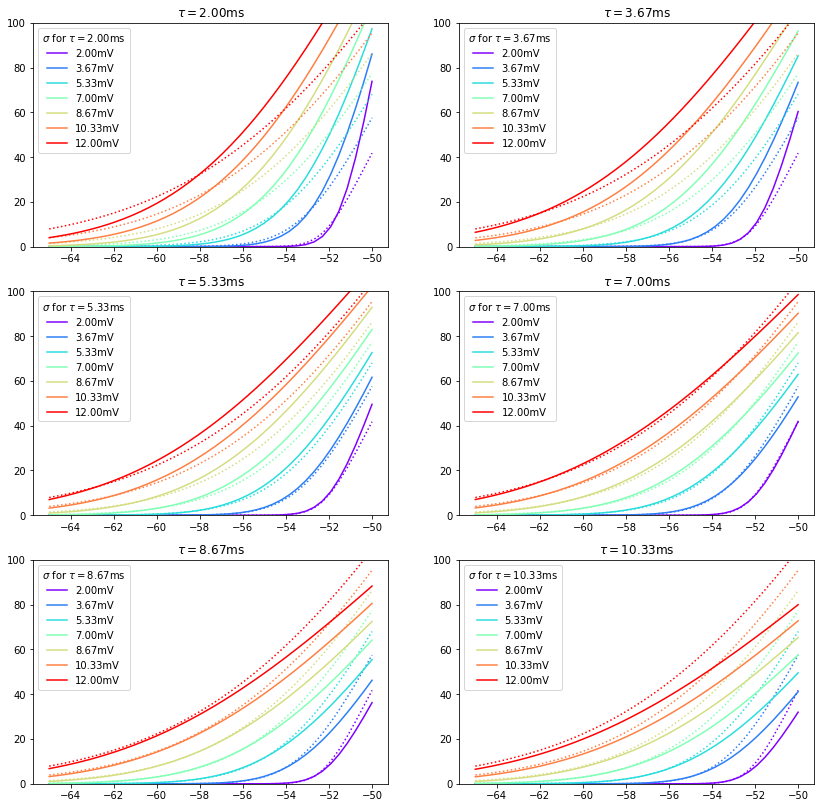

In [545]:
fig, axes = plt.subplots(3, 2, figsize=(14,14))

cmap = plt.cm.rainbow
# tau = tau_vals[3]
for k in range(3):
    for l in range(2):
        ax = axes[k, l]
        tau = tau_vals[k*2 + l]
        for i, sigma in enumerate(sigma_vals):
            c_E, I_E, g_E = params_from_individual(individual, sigma / b2.mV, tau/b2.ms)
            estimates = approximate_function(c_E, I_E, g_E, I_syn)

            ax.plot(
                V_SS / b2.mV, estimates,
                ':', color=cmap(i/(len(sigma_vals)-1)))
            ax.plot(
                V_SS / b2.mV, true_values[(sigma/b2.mV, tau/b2.ms)],
                color=cmap(i/(len(sigma_vals)-1)), label=f"{sigma/b2.mV:.2f}mV")
        ax.legend(title=fr'$\sigma$ for $\tau={tau/b2.ms:.2f}$ms')
        ax.set_title(fr'$\tau={tau / b2.ms:.2f}$ms')
#         ax.set_xlim([-70.0, -50.0])
        ax.set_ylim([0, 100])
plt.show()

In [419]:
s = 2
params_from_individual([
    430.80898505759916,
    0.04352110372255758,
    200.99446756245254,
    -0.060149614064543645,
    0.6548412968633671,
    -1.3371734313636725
], sigma=s),\
params_from_individual([
    814.799420947157,
    -0.04126504214659975,
    383.2270420418161,
    -0.1329176864181992,
    0.3627055979876796,
    -1.245927817693344
], sigma=s),\
params_from_individual([
    1278.3592768498725,
    -0.11975914146008029,
    605.3067524760819,
    -0.19708925792096302,
    0.23451203253074782,
    -1.145067381066401
], sigma=s)

((444.00300573580523, 192.78678700856256, 0.2591831403826585),
 (791.824064269922, 349.49738971597554, 0.1529299733907297),
 (1176.5268248686073, 528.0143677451887, 0.10603897034000881))

An optimal individual for $\tau_m=10$mV:
```
[430.80898505759916,
 0.04352110372255758,
 200.99446756245254,
 -0.060149614064543645,
 0.6548412968633671,
 -1.3371734313636725]
```

An optimal individual for $\tau_m = 5$mV:
```
[814.799420947157,
 -0.04126504214659975,
 383.2270420418161,
 -0.1329176864181992,
 0.3627055979876796,
 -1.245927817693344]
```

An optimal individual (for $\tau_m = 3$mV, I think... or 10??):
```
[1278.3592768498725,
 -0.11975914146008029,
 605.3067524760819,
 -0.19708925792096302,
 0.23451203253074782,
 -1.145067381066401]
```

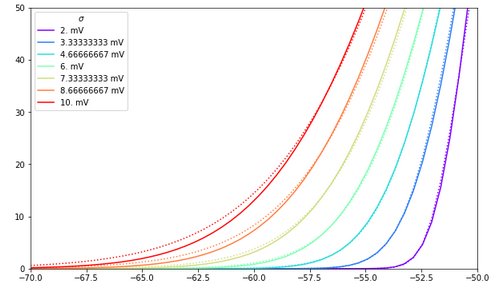